<a href="https://colab.research.google.com/github/InhyeokYoo/Pytorch-study/blob/master/NLP_FROM_SCRATCH_CLASSIFYING_NAMES_WITH_A_CHARACTER_LEVEL_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html 를 참고하여 작성한 자료입니다.

이번 노트북에서는 character-level RNN을 만들고 학습시켜 단어를 분류해보겠습니다. 이 튜토리얼에서는 NLP 모델링을 위해 데이터 전처리를 어떻게 하는지, 특히 *torchtest*의 편리한 기능을 사용하지 않고 처음부터(from scratch)시작해보겠습니다. 이를 통해 NLP 모델링을 위한 전처리를 low-level부터 배워볼 것입니다.

Character-level RNN은 단어를 읽어들일 때 이를 characters의 연속으로 받아들입니다. 마지막 예측단계에서는 단어가 어느 클래스에 속하는지 예측할 것 입니다.

구체적으로 18개의 언어로부터 추출한 몇 천개의 성(surname)을 학습시키고, 어떤 언어에 속하는지를 예측합니다:

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch

```

## 하기전에 보면 좋을 것들
이 튜토리얼을 보고 따라하는 사람은 최소한 PyTorch가 설치되어있고 Python을 다룰줄 알며, Tensors에 대해 이해할 것이라 가정합니다.
- https://pytorch.org/ For installation instructions
- Deep Learning with PyTorch: A 60 Minute Blitz to get started with PyTorch in general
- Learning PyTorch with Examples for a wide and deep overview
- PyTorch for Former Torch Users if you are former Lua Torch user

RNN에 대해 알고 어떻게 작동하는지 알면 더 좋을 것입니다:

- The Unreasonable Effectiveness of Recurrent Neural Networks shows a bunch of real life examples
- Understanding LSTM Networks is about LSTMs specifically but also informative about RNNs in general

# Preparing Data
데이터는 [다음 링크](https://download.pytorch.org/tutorial/data.zip)에서 받을 수 있습니다.

> 다운받지 않아도 동작할 수 있게끔 처리해놨습니다. 특히 코랩에서 유용할 것입니다.

`data.names`디렉토리에 포함된 파일은 18개의 텍스트 파일로, **[Language].txt**로 저장되어있습니다. 각 파일에는 이름이 저장되어 있고, 이는 한 줄에 한 이름씩, 대부분 로마글자로 쓰여져있습니다 (그러나 여전히 Unicode에서 ASCII로 변환할 필요가 있습니다).

이 튜토리얼에서는 언어 당 이름의 리스트로 이루어진 딕셔너리 `{language: [names ...]}`로 변환하여 사용하겠습니다. 나중에 확장하기 용이하도록 language와 name을 일반적인 변수명인 'category'와 'line'으로 표기하겠습니다.



In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2020-01-21 09:43:33--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.251.35, 99.84.251.22, 99.84.251.61, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.251.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  17.1MB/s    in 0.2s    

2020-01-21 09:43:33 (17.1 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [0]:
### Import Libraries
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string

glob 라이브러리는 윈도우의 dir 명령어나 리눅스의 ls 명령어와 유사한 기능을 제공합니다. 이를 통해 파일의 목록을 뽑아보도록 하겠습니다.

In [0]:
# path 내에 있는 모든 파일의 목록을 뽑음.
def find_files(path): return glob.glob(path)

# *은 어떠한 파일명이든 상관없이 뽑음. 즉, 모든 txt파일을 추출함
print(find_files('data/names/*.txt'))

['data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Vietnamese.txt', 'data/names/Arabic.txt', 'data/names/Scottish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Chinese.txt', 'data/names/Spanish.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Czech.txt', 'data/names/English.txt']


In [0]:
all_letters = string.ascii_letters + " .,;'"    # "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [0]:
### 실제 어떻게 동작하는지에 대한 예시

s = 'Ślusàrski'
c = unicodedata.normalize('NFD', s)
print(c)
for i in c:
    # 위첨자는 빠지는 모습을 볼 수 있음.
    print(f"{i}:{unicodedata.category(i)}")   

Ślusàrski
S:Lu
́:Mn
l:Ll
u:Ll
s:Ll
a:Ll
̀:Mn
r:Ll
s:Ll
k:Ll
i:Ll


In [0]:
category_lines = {} # 언어:이름 쌍을 넣을 딕셔너리
all_categories = [] # 모든 언어를 넣을 리스트

# 파일을 읽고 라인별로 split함.
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

# 파일명으로 부터 언어명을 추출하고, 위에서 만들었던 리스트/딕셔너리에 이를 집어넣음.
for filename in find_files('data/names/*.txt'):
    # splittext: 파일명과 확장자를 나누어 반환
    # basename: 디렉토리를 제외한 파일명을 반환한다.
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

이제 `category_lines`에는 각 category(language)와 lines(names)의 리스트로 이루어진 딕셔너리 맵핑이 있을 것입니다. 또한, 추후에 참고하기 위해 `all_categories`(a list of languages)와 `n_categories`를 기록해놓겠습니다.

In [0]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


# 이름을 Tensor로 바꾸기
이제 모든 이름을 정렬했으니, 이를 Tensor로 바꿔주도록 하겠습니다.

한 글자(a single letter)를 표현하기 위해, 사이즈가 `<1 x n_letters>`인 *one-hot vector*를 이용하겠습니다.

단어를 만들기 위해서 이러한 one-hot vector 여러개를 모아 2D matrix `<line_length x 1 x n_letters>`로 만들도록 하겠습니다.

위에서 여분의 1 dimension이 있는 것은 PyTorch는 모든 것을 batch로 받기 때문입니다. 여기서는 batch size를 1로 하겠습니다.

In [0]:
import torch

# all_letters로부터 글자의 index를 찾습니다. e.g. 'a' = 0
def letter_to_index(letter):
    return all_letters.find(letter)

# 글자를 one-hot vector로 바꿈
def letter_to_tensor(letter):
    # vector가 아닌 1 x n의 matrix임에 유의
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# line을 <n_length x 1 x n_letters>로 변환하거나,
# one-hot vector의 array로 변환함.
def line_to_tensor(line):
    # <line_length x 1 x n_letters> 차원의 tensor를 미리 만듬
    tensor = torch.zeros(len(line), 1, n_letters)
    # tensor에 이름(line)의 각 글자의 index를 1로 만듬.
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor

print(letter_to_tensor('J'))

print(line_to_tensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# 네트워크 만들기 (Creating the Network)

Autograd 전에, RNN을 만드는 것은 여러 timesteps을 거쳐 레이어의 파라미터를 복사하는 과정을 포함합니다. 레이어에는 hidden state와 gradient가 들어 있고, hidden state와 gradient는 graph를 통해 처리할 수 있습니다. 이는 우리가 RNN을 일반적인 feed forward network와 같은 매우 **순수한** 방법으로 구현할 수 있다는 뜻입니다.

이 RNN 모듈은 (대부분 [the PyTorch for Torch users tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net)에서 가져왔음) input/hidden state에서 동작하는 두 개의 linear layers와 LogSoftmax 레이어로 이루어져있습니다.

> 원본은 nn.RNN대신 직접 만들어 사용합니다.

![](https://i.imgur.com/Z2xbySO.png)

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # 위 그림 참고
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # torch.cat: 합칠 텐서를 python sequence로 받음.
        combined = torch.cat(tensors=(input, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
# t시점의 input은 글자의 index이므로 n_letters만큼의 차원을 갖음.
rnn = RNN(n_letters, n_hidden, n_categories)

> nn.RNN을 사용할 경우, output의 dimension이 `<seq_len, batch, num_directions * hidden_size>`이므로, FC layer를 통해 `n_categories` 만큼의 차원을 갖도록 바꿔주어야 합니다.

이 네트워크를 실행하기 위해 input(현재 글자)와 이전 hidden state(맨 처음 0으로 초기화한 것)를 넘겨줄 필요가 있습니다.

In [0]:
input = letter_to_tensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

효율성을 생각한다면 모든 step에서 새로운 Tensor를 만들 필요가 없습니다. 따라서 `letters_to_tensor`대신 `line_to_tensor`를 사용하고 slice를 사용하겠습니다. 이는 Tensor의 batch를 pre-computing하여 더 최적화 할 수 있습니다.

In [0]:
input = line_to_tensor('Albert')
hidden = torch.zeros(1, n_hidden)

# 'Albert'의 'A'(t=1)만 전달.
output, next_hidden = rnn(input[0], hidden)
print(output)   # <1 x n_categories>

tensor([[-2.8203, -2.9312, -2.9243, -2.9394, -2.7699, -2.9901, -2.8974, -2.8139,
         -2.8378, -2.9212, -2.9586, -2.8785, -2.8003, -2.8743, -2.8249, -2.9790,
         -2.9449, -2.9594]], grad_fn=<LogSoftmaxBackward>)


결과에서 볼 수 있듯, output은 `<1 x n_categories>` Tensor로, 모든 item은  category의 likelihood가 됩니다 (높을수록 확률이 높습니다)

# Training
## 학습을 위한 준비과정
학습을 시작하기 전에 도움이 될만한 함수를 만들겠습니다. 첫번째 함수는 네트워크의 output을 해석하는 함수로, 각 category의 likelihood입니다. `Tensor.topk`를 사용하여 가장 큰 값의 index를 구할 수 있습니다:
 


In [0]:
def category_from_output(output):
    # torch.topk: return tok K values and indices
    top_n, top_i = output.topk(1)
    # torch.Tensor.item(): return value of this tensor
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

('Russian', 10)


또한 training example을 얻는 빠른 방법을 보겠습니다.

In [0]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    # 랜덤하게 학습예제를 얻는 함수

    # all_categories로부터 랜덤한 학습예제를 샘플링.
    category = random_choice(all_categories)
    # 위에서 선택한 category(i.e. language)로부터 학습할 이름을 샘플링.
    line = random_choice(category_lines[category])
    # category index를 tensor 형태로 변환함.
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)  # <line_length x 1 x n_letters> == <5 x 1 x 57>
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print(f"category = {category},/ line = {line}")

category = Portuguese,/ line = Alves
category = English,/ line = Little
category = Chinese,/ line = Fan
category = Arabic,/ line = Hajjar
category = Irish,/ line = Macdermott
category = Chinese,/ line = Geng
category = French,/ line = Romilly
category = Arabic,/ line = Bitar
category = Portuguese,/ line = D'cruze
category = Portuguese,/ line = Ferro
torch.Size([5, 1, 57])


## Network 학습

loss function의 경우 마지막 레이어에서 `nn.LogSoftmax`를 사용했기 때문에 `nn.NLLLoss`가 적절합니다.

>  Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network. You may use CrossEntropyLoss instead, if you prefer not to add an extra layer.  
- Input: (N, C)  
- Target: (N)

In [0]:
criterion = nn.NLLLoss()

training 과정에서의 매 loop에서 할 일은:
- input과 target tensors를 만든다.
- 0으로 초기화된 initial hidden state를 만든다.
- 각 글자를 읽어들인다.
 - 다음 글자를 위해 hidden state를 저장한다.
- 마지막 output과 target을 비교한다.
- Back-propagation을 수행한다.
- Output과 loss를 반환한다.

In [0]:
learning_rate = 0.005   # 너무 클 경우 explode하고, 작을 경우 학습이 되지 않습니다.

# 원본에선 Optimizer를 사용하는 대신 직접 gradient를 계산합니다.
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    # 0으로 초기화된 initial hidden state를 만든다.
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    # 각 글자를 읽어들인다.
    for i in range(line_tensor.size()[0]):
        # 다음 글자를 위해 hidden state를 저장한다.
        output, hidden = rnn(line_tensor[i], hidden)
    # 마지막 output과 target을 비교한다.
    loss = criterion(output, category_tensor)
    # Back-propagation을 수행한다.
    # Graident가 쌓여야 하므로 RNN이 다 돌았을 때 back-prop을 해줍니다.
    loss.backward()
    '''
    # 원본은 step을 사용하는 대신 아래와 같은 방법으로 시도합니다.

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    '''
    optimizer.step()
    # output과 loss를 반환한다.
    return output, loss.item()

이제 한 뭉치의 예제 (a bunch of example)을 통해 실행시키면 됩니다. `train` 함수는 output과 loss를 반환하기 때문에, 예측값과 loss값을 plotting할 수 있습니다. 

In [0]:
import time
import math

n_iters = 100000
# 일부분만 출력/plotting
print_every = 5000
plot_every = 1000

# loss값을 기록하기
current_loss = 0
all_losses = []

def time_since(since):
    # 시작점(since)과 현재 시간의 차이를 반환하는 함수

    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f"{m}m {s}s"

start = time.time()

for iter in range(1, n_iters + 1):
    # input과 target tensors를 만든다.
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # print iter number, loss, name and guess
    if iter % print_every == 0:
        # 이전에 정의한 output interpreter를 이용하여 예측값 출력
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else f'✗ {category}'
        # iter, 진행률, 걸린시간, loss, 이름, prediction, 정답
        print(f"{iter} {iter/n_iters * 100}% ({time_since(start)}) {loss} {line} {guess} {correct}")

    # 현재 avg loss list of losses에 저장함
    if iter % plot_every == 0:
        all_losses.append(current_loss/ plot_every)
        current_loss = 0

5000 5.0% (0m 5.769678831100464s) 2.3346517086029053 Jarsky Russian ✓
10000 10.0% (0m 11.287590980529785s) 2.492717981338501 Almeida Czech ✗ Portuguese
15000 15.0% (0m 17.23438858985901s) 1.296158790588379 Zhui Chinese ✓
20000 20.0% (0m 23.064869165420532s) 2.29429292678833 Holub Arabic ✗ Czech
25000 25.0% (0m 28.62803602218628s) 0.5351735353469849 Nelli Italian ✓
30000 30.0% (0m 35.078956842422485s) 1.328761339187622 Borovsky Russian ✗ Czech
35000 35.0% (0m 41.236451148986816s) 1.7228971719741821 Bazzi Italian ✗ Arabic
40000 40.0% (0m 47.063740491867065s) 1.3786357641220093 Araullo Italian ✗ Spanish
45000 45.0% (0m 53.35244631767273s) 0.5496755838394165 Qing Chinese ✓
50000 50.0% (0m 59.5142924785614s) 2.987123489379883 Baz Chinese ✗ Arabic
55000 55.00000000000001% (1m 5.926255464553833s) 0.05695939436554909 Strilakos Greek ✓
60000 60.0% (1m 11.774405241012573s) 1.0855873823165894 Maradona Spanish ✓
65000 65.0% (1m 17.6542227268219s) 0.2468671351671219 Dinh Vietnamese ✓
70000 70.0% (1

# Plotting the Result

`all_losses`에 저장된 loss값들을 그려보면 network의 학습하는 과정을 볼 수 있습니다.

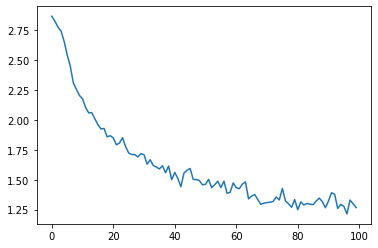

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 결과 평가하기
다른 카테고리에서 네트워크가 얼마나 잘 작동하는지 보기 위해 confusion matrix를 만들겠습니다. Confusion matrix는 모든 정답 언어(row)와 네트워크의 예측(column)을 보여줍니다. Confusion matrix를 만들기 위해서는 sample 뭉치를 `evaluate()`를 통하여 네트워크를 실행시키면 됩니다.


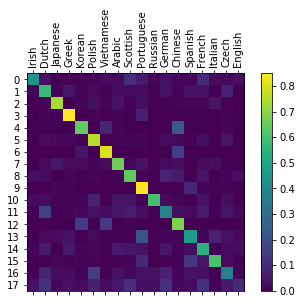

In [0]:
# Confusion matrix에서 정답의 개수를 기록
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# line에 대해 output을 return함.
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예제를 넣고 얼마나 맞는지 확인함.
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# row의 합으로 나누어 normalize
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Plot 세팅
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# axes 세팅
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_xticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# 사용자 데이터로 예측하기

In [0]:
def predict(input_line, n_predictions=3):
    print(f"\n> {input_line}")
    # prediction
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Top N category
        topv, topi = output.topk(n_predictions, 1, True)

        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f'{value:.2f} {all_categories[category_index]}')
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

predict('Yoon')
predict('Yoo')


> Dovesky
-0.52 Russian
-1.29 Czech
-2.61 Polish

> Jackson
-0.45 Scottish
-2.07 English
-2.58 Polish

> Satoshi
-1.05 Arabic
-1.51 Japanese
-1.67 Italian

> Yoon
-0.42 Korean
-1.30 Chinese
-4.11 English

> Yoo
-0.28 Korean
-1.50 Chinese
-5.21 Vietnamese
